In [1]:
import math
import scipy.special,scipy.linalg
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_mldata

## Generate Data (Gaussian mixture or from the MNIST database)

In [2]:
def gen_data(testcase,T,p,cs,means=None,covs=None):
    rng = np.random
    
    if testcase is 'MNIST':
        mnist=fetch_mldata('MNIST original')
        data,labels = mnist.data,mnist.target
        
        # feel free to choose the number you like :)
        selected_target = [6,8]
        p = 784
        K = len(selected_target)
        
        # get the whole set of selected number 
        data_full = []
        data_full_matrix = np.array([]).reshape(p,0)
        ind=0
        for i in selected_target:
            locate_target_train = np.where(labels==i)[0]
            data_full.append(data[locate_target_train].T)
            data_full_matrix = np.concatenate( (data_full_matrix,data[locate_target_train].T), axis=1)
            ind+=1
        

        # recentering and normalization to satisfy Assumption 1 and
        T_full = data_full_matrix.shape[1]
        mean_selected_data = np.mean(data_full_matrix,axis=1).reshape(p,1)
        norm2_selected_data = np.sum((data_full_matrix - np.mean(data_full_matrix,axis=1).reshape(p,1) )**2,(0,1))/T_full
        for i in range(K):
            data_full[i] = data_full[i] - mean_selected_data
            data_full[i] = data_full[i]*np.sqrt(p)/np.sqrt(norm2_selected_data)
            
        
        # get the statistics of MNIST data
        means = []
        covs = []
        for i in range(K):
            data_tmp = data_full[i]
            T_tmp = data_tmp.shape[1]
            means.append(np.mean(data_tmp,axis=1).reshape(p,1))
            covs.append( (data_tmp@(data_tmp.T)/T_tmp - means[i]@(means[i].T)).reshape(p,p))
        
        X = np.array([]).reshape(p,0)
        Omega = np.array([]).reshape(p,0)
        y = []
        
        ind=0
        for i in range(K):
            data_tmp = data_full[i]
            X = np.concatenate((X,data_tmp[:,range(np.int(cs[ind]*T))]),axis=1)
            Omega = np.concatenate((Omega,data_tmp[:,range(np.int(cs[ind]*T))] - np.outer(means[ind],np.ones((1,np.int(T*cs[ind]) ))) ),axis=1)
            y = np.concatenate( (y,2*(ind-K/2+.5)*np.ones(np.int(T*cs[ind]))) )
            ind+=1                       
        
    else:
        X = np.array([]).reshape(p,0)    
        Omega = np.array([]).reshape(p,0)
        y = []
        
        K = len(cs)
        for i in range(K):
            tmp = rng.multivariate_normal(means[i],covs[i],size=np.int(T*cs[i])).T
            X = np.concatenate((X,tmp),axis=1)
            Omega = np.concatenate((Omega,tmp-np.outer(means[i],np.ones((1,np.int(T*cs[i])))) ),axis=1)
            y = np.concatenate( (y,2*(i-K/2+.5)*np.ones(np.int(T*cs[i]))) )
            
    X = X/np.sqrt(p)
    Omega = Omega/np.sqrt(p)
            
    return X,Omega,y,means,covs

## Generate activation functions ($\sigma$)

In [16]:
# Just a copy-paste of Table 2
def gen_sig(fun,Z,tau,coeff=None):
    
    if fun is 't':
        sig = Z
        d = [0,1,0]
    elif fun is 'ReLU':
        sig = np.maximum(Z,0)
        d = [(1/4-1/(2*np.pi))*tau,1/4,1/(8*np.pi*tau)]
    elif fun is 'abs':
        sig = np.abs(Z)
        d = [(1-2/np.pi)*tau,0,1/(2*np.pi*tau)]
    elif fun is 'LReLU':
        sig = coeff[0]*np.maximum(Z,0)+coeff[1]*np.maximum(-Z,0)
        d = [(np.pi-2)/(4*np.pi)*tau*(coeff[0]+coeff[1])**2,(coeff[0]-coeff[1])**2/4,(coeff[0]+coeff[1])**2/(8*np.pi*tau)]
    elif fun is 'posit':
        sig = (Z>0).astype(int)
        d = [1/4-1/(2*np.pi),1/(2*np.pi*tau),0]
    elif fun is 'sign':
        sig = np.sign(Z)
        d = [1-2/np.pi,2/(np.pi*tau),0]
    elif fun is 'poly2':
        sig = coeff[0]*Z**2+coeff[1]*Z+coeff[2]
        d = [2*tau**2*coeff[0]**2,coeff[1]**2,coeff[2]**2]
    elif fun is 'cos':
        sig = np.cos(Z)
        d = [1/2+np.exp(-2*tau)/2-np.exp(-tau),0,np.exp(-tau)/4]
    elif fun is 'sin':
        sig = np.sin(Z)
        d = [1/2-np.exp(-2*tau)/2-tau*np.exp(-tau),np.exp(-tau),0]
    elif fun is 'erf':
        sig = scipy.special.erf(Z)
        d = [2/np.pi*(np.arccos(2*tau/(2*tau+1)) - 2*tau/(2*tau+1)),4/np.pi/(2*tau+1),0]
    elif fun is 'exp':
        sig = np.exp(-Z**2/2)
        d = [1/np.sqrt(2*tau+1) - 1/(tau+1),0,1/(4*(tau+1)**3)]
         
    return sig, d

## Estimate $\tau$

In [17]:
def estim_tau(X):
    tau = np.mean(np.diag(X.T@X))
    
    return tau

## Generate the average kernel matrix $\Phi_c$

In [18]:
def gen_Phi(fun,X,n,coeff=None):
    [p,T] = X.shape
    Phi = np.zeros((T,T));
    tau = estim_tau(X)
    
    nb_loops = 500
    for loop in range(nb_loops):
        W = np.random.normal(0,1,(n,p))
        Sigma,_ = gen_sig(fun,W@X,tau,coeff)
        Phi = Phi + (Sigma.T@Sigma)/n/nb_loops
    
    return Phi

# Main code

### Basic settings

In [19]:
testcase = 'MNIST' # testcase for simulation, among 'iid','means','var','orth','mixed','MNIST'
sigma = 'ReLU'
# activation function, among 't', 'ReLu', 'abs', 'LReLU', 'posit', 'sign', 'poly2', 'cos', 'sin', 'erf', 'exp'
coeff = [1,-1]     # parameters of LReLU or poly2 functions
T = 128            # number of data
n = 32             # number of neurons
cs = [1/2,1/2]     # proportions of each class
K = len(cs)

# generate the data matrix with respect to different test cases
if testcase is 'MNIST':
    p = 784
    X,Omega,y,means,covs = gen_data(testcase,T,p,cs)
else:
    # in the case of Gaussian mixture, the dimension of data should be given
    p = 256
    means=[]
    covs=[]
    if testcase is 'iid':
        for i in range(K):
            means.append(np.zeros(p))
            covs.append(np.eye(p))     
    elif testcase is 'means':
        for i in range(K):
            means.append( np.concatenate( (np.zeros(i),4*np.ones(1),np.zeros(p-i-1)) ) )
            covs.append(np.eye(p))
    elif testcase is 'var':
        for i in range(K):
            means.append(np.zeros(p))
            covs.append(np.eye(p)*(1+8*i/np.sqrt(p)))
    elif testcase is 'orth':
        for i in range(K):
            means.append(np.zeros(p))
            covs.append( np.diag(np.concatenate( (np.ones(np.int(np.sum(prop[0:i]*p))),4*np.ones(np.int(prop[i]*p)),np.ones(np.int(np.sum(prop[i+1:]*p))) ) ) ))
    elif testcase is 'mixed':
        for i in range(K):
            means.append( np.concatenate( (np.zeros(i),4*np.ones(1),np.zeros(p-i-1)) ) )
            covs.append((1+4*i/np.sqrt(p))*scipy.linalg.toeplitz( [(.4*i)**x for x in range(p)] ))            

    X,Omega,y,_,_ = gen_data(testcase,T,p,cs,means,covs)


# Compute the average kernel matrix Phi_c with the data
Phi = gen_Phi(sigma,X,n,coeff)
P = np.eye(T) - np.ones((T,T))/T
Phi_c = P@Phi@P

### Generate the asymptotic equivalent $\tilde \Phi_c$ in Theorem 1

In [20]:
tau = estim_tau(X)
M = np.array([]).reshape(p,0)
t0 = []
J = np.zeros((T,K))

for i in range(K):
    M = np.concatenate( (M,means[i].reshape(p,1)), axis=1)
    t0.append(np.trace(covs[i])/p)
    J[:,i] = (y==2*(i-K/2+.5))*1
    
phi = np.diag(Omega.T@Omega - J@t0)
t = (t0 - tau)*np.sqrt(p)
S = np.zeros((K,K))
for i in range(K):
    for j in range(K):
        S[i,j] = np.trace(covs[i]@covs[j])/p


_,d = gen_sig(sigma,0,tau,coeff)

V = np.concatenate( (J/np.sqrt(p), phi.reshape(T,1), (Omega.T)@M ), axis=1)
A11 = d[1]*(M.T)@M + d[2]*(np.outer(t,t) + 2*S)
A = np.zeros( (2*K+1, 2*K+1) )

A[0:K,0:K] = d[1]*(M.T@M)
A[0:K,K] = d[2]*t
A[0:K,K+1:] = d[1]*np.eye(K)
A[K,0:K] = d[2]*t.T
A[K,K] = d[2]
A[K+1:,0:K] = d[1]*np.eye(K)

tilde_Phi = d[1]*(Omega.T)@Omega + V@A@(V.T) + d[0]*np.eye(T)
tilde_Phi_c = P@tilde_Phi@P

print('Statistics of the data')
print(np.linalg.norm( (M.T)@M ))
print(np.linalg.norm( np.outer(t,t)+2*S ))

Statistics of the data
173.483353397
93.0825529431


### Compare the spectrums of $\Phi_c$ and $\tilde \Phi_c$

In [21]:
U_Phi_c,D_Phi_c,_ = np.linalg.svd(Phi_c)
tilde_U_Phi_c,tilde_D_Phi_c,_ = np.linalg.svd(tilde_Phi_c)

#### Eigenvalue distribution

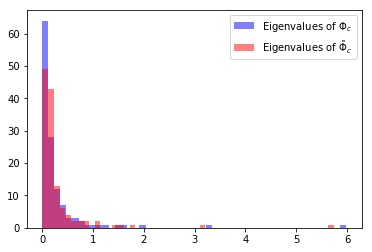

In [34]:
xs = np.linspace( min(D_Phi_c), max(D_Phi_c), 50)
n1, bins1, patches1 ,= plt.hist(D_Phi_c, 50, facecolor='b', alpha=0.5, label='Eigenvalues of $\Phi_c$')
n2, bins2, patches2 ,= plt.hist(tilde_D_Phi_c, 50, facecolor='r', alpha=0.5, label='Eigenvalues of $\~\Phi_c$')
plt.legend()

plt.show()

#### Leading eigenvector

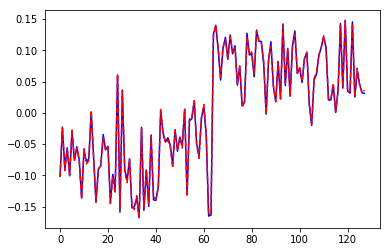

In [29]:
pl1 ,= plt.plot(U_Phi_c[:,0], 'b', label='Leading eigenvector of $\Phi_c$')
pl2 ,= plt.plot(tilde_U_Phi_c[:,0]*np.sign(U_Phi_c[1,0]*tilde_U_Phi_c[1,0]),'r--', label='Leading eigenvector of $\~\Phi_c$')
plt.show()